In [197]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-for-msc-2022-23/example.csv
/kaggle/input/deep-learning-for-msc-2022-23/train.csv
/kaggle/input/deep-learning-for-msc-2022-23/test/14127.png
/kaggle/input/deep-learning-for-msc-2022-23/test/11396.png
/kaggle/input/deep-learning-for-msc-2022-23/test/14260.png
/kaggle/input/deep-learning-for-msc-2022-23/test/12329.png
/kaggle/input/deep-learning-for-msc-2022-23/test/13412.png
/kaggle/input/deep-learning-for-msc-2022-23/test/14325.png
/kaggle/input/deep-learning-for-msc-2022-23/test/13139.png
/kaggle/input/deep-learning-for-msc-2022-23/test/12743.png
/kaggle/input/deep-learning-for-msc-2022-23/test/14990.png
/kaggle/input/deep-learning-for-msc-2022-23/test/10760.png
/kaggle/input/deep-learning-for-msc-2022-23/test/12867.png
/kaggle/input/deep-learning-for-msc-2022-23/test/13570.png
/kaggle/input/deep-learning-for-msc-2022-23/test/12684.png
/kaggle/input/deep-learning-for-msc-2022-23/test/13612.png
/kaggle/input/deep-learning-for-msc-2022-23/test/12204.png
/kagg

# Step 1: preparing the data
we will start will writing a custom data loader to load the images we are working with, into training and validation sets

In [1]:
from __future__ import print_function, division
import os
import torch
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

ModuleNotFoundError: No module named 'skimage'

## 1.1 reading csv file and defining show_img
loading the metadata file of train.csv to get the cell pictures filename and corresponding labels, loading them into array

In [37]:
#load the train.csv into a dataframe
cell_frame = pd.read_csv('/kaggle/input/deep-learning-for-msc-2022-23/train.csv')

In [38]:
cell_frame.shape

(7560, 2)

In [39]:
cell_frame.head()

,Filename,Label
0,1.png,0
1,2.png,0
2,3.png,0
3,4.png,0
4,5.png,0


upon checking the respective sample count of each label (0 to 3):

In [40]:
for i in range(4):
    print('items with label 0: ', cell_frame['Label'][cell_frame['Label']==i].count())

items with label 0:  729
items with label 0:  3462
items with label 0:  679
items with label 0:  2690


#### There is a significant inbalance between classes!
where sample of label 0 and 2 is about 4 to 5 times lesser than sample with label 0 and 2<br>
this may pose a problem where the NN we produce can favour its classification output towards 1 & 3 more...<br>
we may want to deal with this problem in the training set:
1. for a classification model with better generalisation
2. (if we are result driven) if the test result set has different label distribution compare to our training dataset (i.e. having more sample with label 0 & 2 in its distribution)

#### dealing with class imbalance method 1: data augmentation
One way to deal with the class imbalance easily is to deal with this **dataframe** first - we **duplicate the samples of minor classes** in the df. The *duplication will be canceled out* when we initiate the CellsDataset later with **random custom transformations**.

In [41]:
# #creating a balanced cell_frame, lets call it bell_frame
# bell_frame = cell_frame.copy()
# #create label 0 and 2 only copies from bell_frame
# bell_02 = bell_frame[bell_frame['Label'].isin([0,2])]
# #concate them back to bell_frame, do it 3 times
# bell_frame = pd.concat([bell_frame, bell_02,bell_02,bell_02])
# #shuffle them
# bell_frame = bell_frame.sample(frac=1).reset_index(drop=True)

In [42]:
# #checking the label of the balanced dataset
# for i in range(4):
#     print('items with label 0: ', bell_frame['Label'][bell_frame['Label']==i].count())

upon testing, this method is not feasible as there is serious bottleneck in CPU for data augmentation. due to the time constraint, this is left for future work.

#### dealing with class imbalance method 2: downsampling
downsampling the class 1 & 3, sampling 700 out of each class, making class 0~3 about even<br>
this method is simple to do and lessen the computation load.


In [43]:
# #creating a downsampled cell_frame, lets call it down_frame
# down_frame = cell_frame.copy()
# #create label 1 and 3 only copies from bell_frame
# down0 = down_frame[down_frame['Label']==0]
# down1 = down_frame[down_frame['Label']==1]
# down2 = down_frame[down_frame['Label']==2]
# down3 = down_frame[down_frame['Label']==3]
# #randomly sample class 1 & 3
# down1 = down1.sample(n=700)
# down3 = down3.sample(n=700)
# #concate them back to bell_frame, do it 3 times
# down_frame = pd.concat([down0,down1,down2,down3])
# #shuffle them
# down_frame = down_frame.sample(frac=1).reset_index(drop=True)

In [44]:
# #checking the downsampled dataframe
# for i in range(4):
#     print('items with label 0: ', down_frame['Label'][down_frame['Label']==i].count())

items with label 0:  729
items with label 0:  700
items with label 0:  679
items with label 0:  700


upon testing, this method does not work as well as our method 3, which will be presented below. We will not proceed with this method and its dataset

#### dealing with class imbalance method 3 :weighted loss function
to modify the loss function (cross entropy loss in this case), we have to calculate custom weight for each of the classes to counter balance it (somehow sounds cool)<br>
reference: https://medium.com/@matrixB/modified-cross-entropy-loss-for-multi-label-classification-with-class-a8afede21eb9

In [45]:
#getting the count difference of classes
for i in range(4):
    print('items with label 0: ', cell_frame['Label'][cell_frame['Label']==i].count())

items with label 0:  729
items with label 0:  3462
items with label 0:  679
items with label 0:  2690


In [46]:
#calculating class weights
N = len(cell_frame) # 7560
labels = np.arange(0,4)

weights = []

for i in range(4):
    weights.append(N /(2 * sum(cell_frame['Label'] == i)))
    
weights

[5.185185185185185, 1.0918544194107451, 5.56701030927835, 1.4052044609665428]

In [47]:
#defining a function to show cell pic along with its label, showing training data below:
def show_img(image, labels):
    """Show image with labels"""
    plt.imshow(image)
    plt.xlabel('label: {}'.format(labels))
    print("label: ", labels)


## 1.2 Dataset class
using *torch.utils.data.Dataset* produce a custom dataset class for the cell images we are using. we will have to override:
* the __len__ (for len(dataset) to return the size of the dataset) 
* __getitem__ methods (for dataset[i] to trutn the ith sample)

In [48]:
class CellsDataset(Dataset):
    """Cells dataset."""

#     def __init__(self, csv_file, root_dir, transform=None):
    def __init__(self, df, root_dir, transform=None): 
        """
        Args:
            df(dataframe): takes the dataframe produced by pd.read_csv(path to csv file with annotations)
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
#         self.cell_frame = pd.read_csv(csv_file)
        self.cell_frame = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.cell_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.cell_frame.iloc[idx, 0])
        image = io.imread(img_name)
        labels = self.cell_frame.iloc[idx, 1]
        labels = np.array([labels])
        sample = {'image': image, 'labels': labels}
        if self.transform: 
            sample = self.transform(sample)

        return sample

try to instantiate this class and iterate throught the datat samples, then print first 4 samples and their labels.

0 (100, 100, 3) (1,)
label:  [1]
1 (100, 100, 3) (1,)
label:  [1]
2 (100, 100, 3) (1,)
label:  [2]
3 (100, 100, 3) (1,)
label:  [0]


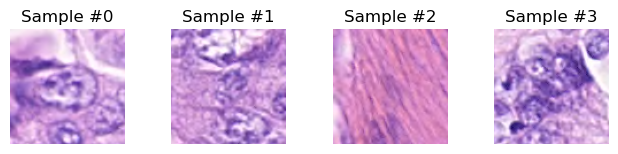

In [49]:
cell_dataset = CellsDataset(df=down_frame,root_dir='/kaggle/input/deep-learning-for-msc-2022-23/train/')

fig = plt.figure()

for i in range(len(cell_dataset)):
    sample = cell_dataset[i]
#     print(i, sample['image'].type)
    print(i, sample['image'].shape, sample['labels'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
#     plt.xlabel('label: {}'.format(labels))
    ax.set_title('Sample #{}'.format(i))
#     ax.xlabel('label: {}'.format(labels))
    ax.axis('off')
    show_img(**sample)

    if i == 3:
        plt.show()
        break

even though all the images are of same size (100,100,3), we still need to define the transform function to ensure the *.size()* function (from torch.Tensor) is callable on the image & labels objects in the CellsDataset. The *.size()* function is crucial for the *show_labels* function later on right after initiating the DataLoader object

## 1.3 Transforms
we are only really using *ToTensor()*, as it is the only thing we really need (to convert numpy images into Torch images)<br>
this is achieved by swapping the axes<br><br>
*more transformation for Data Augmentation (to deal with class imbalance) is defined, but the approach is not carried out due to CPU bottleneck, more explaination below*<br>
types of Augmentation defined:
* mirroring - ++RandomHorizontalFlip()?
* adding noise

In [50]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'labels': torch.from_numpy(labels)}
#                 'labels': labels}

#### data augmentation: custom transformation
basic idea as below:
1. flipping: get value of max width and height of image - 100, take each pixel of current image, and paste at opposite position of a new image (fixing either one of the axes), can do max-1-i or -i
2. dropout: for i = blackened_pixels_count, randomly pick pixels within range (100,100) and turn the value into 3rd dimension into 0?

### after testing the training process on model1, we will have to abort the data augmentation for now due to a few reason:
1. there is significant cpu bottlenecking as all the numpy calculation is done on cpu, it takes too long to run
2. there is technical difficulties to move the augmentation on CPU as we need to convert numpy array to tensor first then move to GPU<br><br>

may want to transform the dataset and store offline instead of loading and transforming one by one during training?

In [51]:
class RandomVFlip(object):
    """flip the image vertically

    create a new image, where all the original image's row value is changed to 99-row, while column is kept the same
    """

    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']
#         image = image.to(device)#attempt to put image on GPU, to solve CPU bottleneck
        new_image = np.empty_like(image) #the funciton will be called ahead of ToTensor(), so the image is nparray
        
        for h in range(100):
            for w in range(100):
                new_h = abs(99-int(h)) #flip the vertical
                w = int(w)
                new_image[new_h, w] = image[h, w] #assign the values from ori image to new image
                
        choice = [True, False]
        if(np.random.choice(choice, 1, p=[0.4, 0.6])): #there is a 40% percent chance for this transformation
            image = new_image

        return {'image': image, 'labels': labels}

class RandomHFlip(object):
    """flip the image horizontally

    create a new image, where all the original image's col value is changed to 99-col, while row is kept the same
    """

    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']
#         image = image.to(device)#attempt to put image on GPU, to solve CPU bottleneck
        new_image = np.empty_like(image) #the funciton will be called ahead of ToTensor(), so the image is nparray
        
        for h in range(100):
            for w in range(100):
                new_w = abs(99-int(w)) #flip the vertical
                h = int(h)
                new_image[h, new_w] = image[h, w] #assign the values from ori image to new image
        
        choice = [True, False]
        if(np.random.choice(choice, 1, p=[0.4, 0.6])): #there is a 40% percent chance for this transformation
            image = new_image

        return {'image': image, 'labels': labels}
    
class RandomDropout(object):
    """black out pixels randomly - similar to adding noise

    for 1500 loop, randomly generate x and y values, then assign empty array values (black) to the selected pixel
    """

    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']
        #we are still using a new image, because we want to randomly trigger this
#         image = image.to(device)#attempt to put image on GPU, to solve CPU bottleneck
        new_image = np.copy(image) #create an exact replica
        pixel = image[0,0]
        dropout = np.empty_like(pixel) #dropout pixel
        for i in range(1500):
            drop_x = np.random.randint(0,100) #choose a random x for dropout pixel
            drop_y = np.random.randint(0,100) #choose a random y for dropout pixel
            new_image[drop_x, drop_y] = dropout #the chosen pixel is assigned black
            
        choice = [True, False]
        if(np.random.choice(choice, 1, p=[0.4, 0.6])): #there is a 30% percent chance for this transformation
            image = new_image

        return {'image': image, 'labels': labels}


### Iterating through the dataset
Next, we will try to iterate through the dataset to ensure that the dataset is sampled correctly, i.e. each time the dataset is sampled:
* an image is read from the file on the fly
* images are transformed (ToTensor) into tensor images
lets iterate through a "for i in range" loop

In [52]:
# tt = transforms.Compose([
# #     ToTensor(), #try to convert to Tensor first, so we can run augmentation on GPU (solve CPU bottleneck)
#     #custom flip horizontal
#     RandomHFlip(),
#     #custom flip vertical
#     RandomVFlip(),
#     #custom dropout  
#     RandomDropout(),
#     ToTensor()
# ])


dataset = CellsDataset(df=cell_frame, root_dir='/kaggle/input/deep-learning-for-msc-2022-23/train/',
                                   transform = ToTensor())

## 1.4 Loading the dataset into torch.utils.data.Dataloader
and split it into training and validation set<br>
splitting custom dataset to training and validation set using SubsetRandomSampler: https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

In [53]:
# Helper function to show a batch
def show_labels_batch(sample_batched):
    """Show image with labels for a batch of samples."""
    images_batch, labels_batch = \
            sample_batched['image'], sample_batched['labels']
    batch_size = len(images_batch) 
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

# 2. Creating CNN models
We are going with 2 models:
1. **Model1**, a small CNN, with no more than 8 layers, and is train from scratch in this notebook
2. **Model2**, an existing torchvision model - ResNet18, pretrained on ImageNet, and modified to suit this usecase

In [54]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
#setup device, to use GPU for CNN models
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

## 2.1a 8-layer CNN model
this model has 2 convolutional layers, 2 maxpool layers, 3 linear layers. softmax layer is not needed as our cost function, CrossEntropyLoss, includes it internally.

In [56]:
import collections

model1 = nn.Sequential(collections.OrderedDict([
#           ('conv1', nn.Conv2d(3,16,5,padding=2)),
          ('conv1', nn.Conv2d(3,16,5,padding=2, bias=False)),
          ('relu1', nn.ReLU()),
          ('pool1', nn.MaxPool2d(kernel_size=2, stride=2)),
#           ('conv2', nn.Conv2d(16,32,5,padding=2)),
          ('conv2', nn.Conv2d(16,32,5,padding=2, bias=False)),
          ('relu2', nn.ReLU()),
          ('pool2', nn.MaxPool2d(kernel_size=2, stride=2)),
          # Put in a linear layers ...
          ('flatten', nn.Flatten()),                                          
          ('fc1', nn.Linear(32*25*25,120)),
          ('relu3', nn.ReLU()),
          ('fc2', nn.Linear(120,84)),#4 class for output label
          ('relu4', nn.ReLU()),
          ('fc3', nn.Linear(84,4)),#4 class for output label
#           ('relu5', nn.ReLU()),
#           ('softmax',nn.Softmax(dim=1))
        ]))

This model is performing weirdly in training...cannot narrow down the issue to training function or model structure for now...may want to revisit this

In [57]:
#checking the model architecture
print("\nCNN Network Model:")
print(model1)


CNN Network Model:
Sequential(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=20000, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)


## 2.1b ResNet18
imported from torchvision.models, then the fully connected layer is modified<br>
finetuning torchvision models: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [294]:
from torchvision import models

# Number of classes in the dataset
num_classes = 4

model2 = models.resnet18(pretrained=True)

since we are aiming for transfer learning here, we will not train the whole ResNet from scratch. Instead, we only train the fully connected layer which we will redefined layer. This is configured with the code below:

In [295]:
# Flag for feature extracting. When False, we finetune the whole model,
# when True we only update the reshaped layer params
feature_extract = True

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
set_parameter_requires_grad(model2, feature_extract) #not retraining the model, use this for the first run

printing to check the model layers below:

In [296]:
#run before and after the modification to check the last layer
model2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

the last layer of the model show:<br>
(fc): Linear(in_features=512, out_features=1000, bias=True)<br>
which is a fully connected layer that takes in 512 features and output 1000 features. 
### Our use case have only 4 classes for the output, so we should modify the last layer to suit our need with the code below:

In [297]:
model2.fc = nn.Linear(512, num_classes)

## Weighted Loss Function
remember we said we are going to counter balance the class imbalance using a custom loss function that weights results from underrepresented class more heavily? now we are going to calculate the weights

In [97]:
#checking the weights of classes
for i in range(4):
    print(i,weights[i])

0 tensor(5.1852, device='cuda:0')
1 tensor(1.0919, device='cuda:0')
2 tensor(5.5670, device='cuda:0')
3 tensor(1.4052, device='cuda:0')


with the weight ready, we can use it as a parameter when we initiate the cross entropy loss.
* also, the custom loss function is only used in training (where we actually need to balance things out)

In [98]:
#turning weights into torch tensor, so that it can be calculated on GPU
weights = torch.tensor(weights).to(device)

## 2.2 define training loop and validation loop?<br>
train & validation functions with results collection method for plotting accuracy and loss curve later...<br>
reference: https://medium.com/dataseries/k-fold-cross-validation-with-pytorch-and-sklearn-d094aa00105f

In [100]:
#using k fold validation
from sklearn.model_selection import KFold
from torch.utils.data import random_split

num_epochs = 10
k=10
splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}

#### the train function (for each epoch) is simple:
* it takes in optimizer, model, device, loss function and dataloader
* goes to training mode
* then for each mini batch of data, performs prediction, calculate loss. 
* the loss is then back-propagated to optimize the weights and bias of the neurons. 
* loss and correct prediction count for each epoch is recorded <br>

#### the validation function (for each epoch):
* takes in model, device, dataloader and loss function
* goes to evaluation mode
* make predictions for each mini batch of data
* compare predictions with ground truth
* record loss and correct prediction count

In [66]:
from torch.utils.data.sampler import SubsetRandomSampler

def train_epoch(optimizer, model, device, loss_fn, train_loader): #train for a single epoch and return results
    train_loss,train_correct=0.0,0
#     model = model.to(device)
    model.train()
    for i_batch, sample_batched in enumerate(train_loader):
        img = sample_batched['image'].float()#need to change to float else will be incompatible with bias/weight
        labels = sample_batched['labels'].flatten() #need to flatten to 1d or 0d, else there will error where the loss fn can't deal with multiclass
        output = model(img.to(device))
        loss = loss_fn(output, labels.to(device))
#         loss = custom_loss(output, labels.to(device))
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
#         train_loss += loss
        train_loss += loss.item()* img.size(0)
#         scores, predictions = torch.max(output.data, 1)#to get the predictions result
        predictions = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        train_correct += (predictions.to(device) == labels.to(device)).sum().item()
    
    return train_loss,train_correct

def valid_epoch(model, device, test_loader, loss_fn):  #validate for a single epoch and return results
    valid_loss, val_correct = 0.0, 0
    model.eval()
#     model = model.to(device)
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(test_loader):
            img = sample_batched['image'].float()#need to change to float else will be incompatible with bias/weight
            labels = sample_batched['labels'].flatten() #need to flatten to 1d or 0d, else there will error where the loss fn can't deal with multiclass
            img, labels = img.to(device), labels.to(device)
            
            output = model(img)
#             valid_loss += loss_fn(output, labels, reduction='sum').item()  # sum up batch loss
#             valid_loss += loss_fn(output, labels).item()
            valid_loss += loss_fn(output, labels).item()*img.size(0)
    
#             scores, predictions = torch.max(output.data,1)
            predictions = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            val_correct+=(predictions == labels).sum().item()
            
    return valid_loss,val_correct

## Model 1 with original dataset, weighted loss function
10-fold validation with 10 epochs for each fold

In [101]:
#confirm it is weighted
weighted_loss_fn.weight

tensor([5.1852, 1.0919, 5.5670, 1.4052], device='cuda:0')

the code below will do 10 fold cross validation, where each fold new training validation split is performed,and the for each epoch (10 epoch each fold) train_epoch and valid_epoch is called.<br>
* take note that the training function uses a weighted loss function while not the validation function.
* the accuracy and loss for each epoch is recorded in the **history1a** dictionary
* the optimiser, Adam, has regularisation applied with weight decay


In [68]:
weighted_loss_fn = nn.CrossEntropyLoss(weight = weights, reduction='sum')
loss_fn = nn.CrossEntropyLoss(reduction='sum')#non weighted loss for validation/test

history1a = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}


#we will call the train and valid epochs in this loop, for num_epoch*k (in k fold validation)
#in this for loop we are calling: model2bal on balanced dataset
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    
    trainloader = DataLoader(dataset, batch_size=4, sampler=train_sampler)
    valloader = DataLoader(dataset, batch_size=4, sampler=test_sampler)
    
    model1.to(device)
#     optimizer = optim.SGD(model2.parameters(), lr=0.001)
    optimizer = optim.Adam(model1.parameters(), weight_decay=0.01, lr=0.001)#applying weight decay using adam

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(optimizer,model1,device,weighted_loss_fn,trainloader)#weighted loss function for training
        test_loss, test_correct=valid_epoch(model1,device,valloader,loss_fn)#non weighted loss for testing

        train_loss = train_loss / len(trainloader.sampler) #length is 2528
        train_acc = train_correct / len(trainloader.sampler) * 10
#         train_acc = train_correct / len(btrainloader.sampler) * 100
        test_loss = test_loss / len(valloader.sampler) #length is 280
        test_acc = test_correct / len(valloader.sampler) * 10
#         test_acc = test_correct / len(bvalloader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.4f} AVG Test Loss:{:.4f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history1a['train_loss'].append(train_loss)
        history1a['test_loss'].append(test_loss)
        history1a['train_acc'].append(train_acc)
        history1a['test_acc'].append(test_acc)   

Fold 1
Epoch:1/10 AVG Training Loss:12.8618 AVG Test Loss:5.5460 AVG Training Acc 8.62 % AVG Test Acc 3.93 %
Epoch:2/10 AVG Training Loss:11.0916 AVG Test Loss:5.5658 AVG Training Acc 9.74 % AVG Test Acc 13.54 %
Epoch:3/10 AVG Training Loss:11.0979 AVG Test Loss:5.6352 AVG Training Acc 12.36 % AVG Test Acc 3.86 %
Epoch:4/10 AVG Training Loss:11.1119 AVG Test Loss:5.5381 AVG Training Acc 6.33 % AVG Test Acc 18.78 %
Epoch:5/10 AVG Training Loss:11.0823 AVG Test Loss:5.5845 AVG Training Acc 12.48 % AVG Test Acc 3.81 %
Epoch:6/10 AVG Training Loss:11.1892 AVG Test Loss:5.5993 AVG Training Acc 9.51 % AVG Test Acc 3.81 %
Epoch:7/10 AVG Training Loss:11.0834 AVG Test Loss:5.5291 AVG Training Acc 5.43 % AVG Test Acc 18.78 %
Epoch:8/10 AVG Training Loss:11.0850 AVG Test Loss:5.5362 AVG Training Acc 10.57 % AVG Test Acc 13.54 %
Epoch:9/10 AVG Training Loss:11.0803 AVG Test Loss:5.4540 AVG Training Acc 10.58 % AVG Test Acc 18.78 %
Epoch:10/10 AVG Training Loss:11.0830 AVG Test Loss:5.4761 AVG Tra

In [69]:
avg_train_loss1a = np.mean(history1a['train_loss'])
avg_test_loss1a = np.mean(history1a['test_loss'])
avg_train_acc1a = np.mean(history1a['train_acc'])
avg_test_acc1a = np.mean(history1a['test_acc'])

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.4f} \t Average Test Loss: {:.4f} \t Average Training Acc: {:.3f} \t Average Test Acc: {:.3f}".format(avg_train_loss1a,avg_test_loss1a,avg_train_acc1a,avg_test_acc1a))  

Performance of 10 fold cross validation
Average Training Loss: 11.1499 	 Average Test Loss: 5.5495 	 Average Training Acc: 8.213 	 Average Test Acc: 8.302


as mentioned, model1, the manually defined model is behaving strangely where the accuracy is wildly inconsistent. we will find out why in a bit.

### Another thing to take note here is that the Accuracy displayed above is faulty, it is not actually not that low - we will have more of an idea when we look at the confusion matrix later.
there might be some fault in the calculations defined in the code above. *However, the accuracy shown above still shows the trend of accuracy and that there are a lot of times the optimisation is stuck in a plateau*

## Model 2 with original dataset, weighted loss function
10-fold validation with 10 epochs for each fold

In [216]:
#confirm it is weighted
weighted_loss_fn.weight

tensor([5.1852, 1.0919, 5.5670, 1.4052], device='cuda:0')

similar to the code for model1, code below will do 10 fold cross validation for **model2**, where each fold new training validation split is performed,and the for each epoch (10 epoch each fold) train_epoch and valid_epoch is called.<br>
* take note that the training function uses a weighted loss function while not the validation function.
* the accuracy and loss for each epoch is recorded in the **history2a** dictionary
* the optimiser, Adam, has regularisation applied with weight decay

In [298]:
weighted_loss_fn = nn.CrossEntropyLoss(weight = weights, reduction='sum')
loss_fn = nn.CrossEntropyLoss(reduction='sum')#non weighted loss for validation/test

history2a = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}


#we will call the train and valid epochs in this loop, for num_epoch*k (in k fold validation)
#in this for loop we are calling: model2bal on balanced dataset
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    
    trainloader = DataLoader(dataset, batch_size=4, sampler=train_sampler)
    valloader = DataLoader(dataset, batch_size=4, sampler=test_sampler)
    
#     model = model2bal
    model2.to(device)
#     optimizer = optim.SGD(model2.parameters(), lr=0.001)
    optimizer = optim.Adam(model2.parameters(), weight_decay=0.0003, lr=0.001)#applying weight decay using adam
#     optimizer = optim.Adam(model2.parameters(), lr=0.001)#applying weight decay using adam

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(optimizer,model2,device,weighted_loss_fn,trainloader)#weighted loss function for training
        test_loss, test_correct=valid_epoch(model2,device,valloader,loss_fn)#non weighted loss for testing

        train_loss = train_loss / len(trainloader.sampler) #length is 2528
        train_acc = train_correct / len(trainloader.sampler) * 10
#         train_acc = train_correct / len(btrainloader.sampler) * 100
        test_loss = test_loss / len(valloader.sampler) #length is 280
        test_acc = test_correct / len(valloader.sampler) * 10
#         test_acc = test_correct / len(bvalloader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.4f} AVG Test Loss:{:.4f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history2a['train_loss'].append(train_loss)
        history2a['test_loss'].append(test_loss)
        history2a['train_acc'].append(train_acc)
        history2a['test_acc'].append(test_acc)   

Fold 1
Epoch:1/10 AVG Training Loss:7.6577 AVG Test Loss:3.0998 AVG Training Acc 12.49 % AVG Test Acc 15.87 %
Epoch:2/10 AVG Training Loss:6.5284 AVG Test Loss:3.1497 AVG Training Acc 13.28 % AVG Test Acc 16.06 %
Epoch:3/10 AVG Training Loss:6.3028 AVG Test Loss:3.2280 AVG Training Acc 13.66 % AVG Test Acc 15.37 %
Epoch:4/10 AVG Training Loss:6.4006 AVG Test Loss:3.2957 AVG Training Acc 13.63 % AVG Test Acc 14.99 %
Epoch:5/10 AVG Training Loss:6.4405 AVG Test Loss:3.0358 AVG Training Acc 13.76 % AVG Test Acc 16.01 %
Epoch:6/10 AVG Training Loss:6.2903 AVG Test Loss:5.3517 AVG Training Acc 13.73 % AVG Test Acc 13.00 %
Epoch:7/10 AVG Training Loss:6.2906 AVG Test Loss:2.7719 AVG Training Acc 13.47 % AVG Test Acc 17.06 %
Epoch:8/10 AVG Training Loss:6.3640 AVG Test Loss:2.8276 AVG Training Acc 13.74 % AVG Test Acc 17.42 %
Epoch:9/10 AVG Training Loss:6.3028 AVG Test Loss:2.9769 AVG Training Acc 13.71 % AVG Test Acc 16.06 %
Epoch:10/10 AVG Training Loss:6.2762 AVG Test Loss:3.0509 AVG Trai

In [299]:
avg_train_loss2a = np.mean(history2a['train_loss'])
avg_test_loss2a = np.mean(history2a['test_loss'])
avg_train_acc2a = np.mean(history2a['train_acc'])
avg_test_acc2a = np.mean(history2a['test_acc'])

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.4f} \t Average Test Loss: {:.4f} \t Average Training Acc: {:.3f} \t Average Test Acc: {:.3f}".format(avg_train_loss2a,avg_test_loss2a,avg_train_acc2a,avg_test_acc2a))  

Performance of 10 fold cross validation
Average Training Loss: 6.2496 	 Average Test Loss: 2.9392 	 Average Training Acc: 13.830 	 Average Test Acc: 16.429


#### Again, the accuracy here is faulty, it acts more as to show the trend of training. 
We will understand the model more in the Interpretation part below.

# 3. Interpreting the model
in this segment we try to understand how the model is working under the hood with the help of tools like:
1. loss-curve
2. confusion matrix
3. Captum

## 3.1 Loss and Accuracy curves 
track the performance of model over time in training and validation, where we can practice early stopping as soon as validation result gets worse.<br>
we will use the history library to help do that

### Model 1 with normal dataset and weighted loss

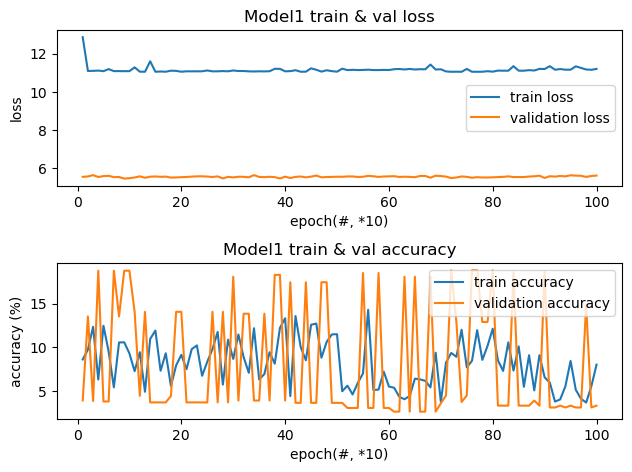

In [105]:
#plot 1:
x = np.arange(1,101)
y1 = history1a['train_loss']
y2 = history1a['test_loss']

plt.subplot(2, 1, 1)
plt.plot(x, y1, label = "train loss")
plt.plot(x, y2, label = "validation loss")
# plt.yticks(np.arange(0,6))
plt.title("Model1 train & val loss")
plt.xlabel("epoch(#, *10)")
plt.ylabel("loss")
plt.legend()
# plt.figure(figsize=(30,10))

#plot 2:
y3 = history1a['train_acc']
y4 = history1a['test_acc']

plt.subplot(2, 1, 2)
plt.plot(x, y3, label = "train accuracy")
plt.plot(x, y4, label = "validation accuracy")
plt.title("Model1 train & val accuracy")
plt.xlabel("epoch(#, *10)")
plt.ylabel("accuracy (%)")
plt.legend()
# plt.figure(figsize=(30,10))

plt.tight_layout(pad=1.0)

plt.show()

### Model 2 with normal dataset and weighted loss

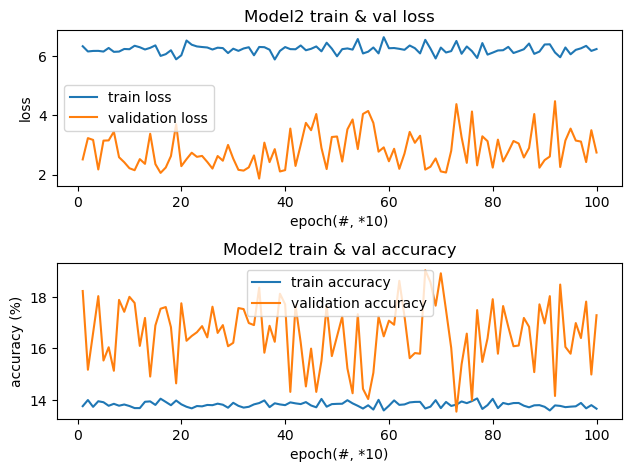

In [106]:
#plot 1:
x = np.arange(1,101)
y1 = history2a['train_loss']
y2 = history2a['test_loss']

plt.subplot(2, 1, 1)
plt.plot(x, y1, label = "train loss")
plt.plot(x, y2, label = "validation loss")
# plt.yticks(np.arange(0,6))
plt.title("Model2 train & val loss")
plt.xlabel("epoch(#, *10)")
plt.ylabel("loss")
plt.legend()
# plt.figure(figsize=(30,10))

#plot 2:
y3 = history2a['train_acc']
y4 = history2a['test_acc']

plt.subplot(2, 1, 2)
plt.plot(x, y3, label = "train accuracy")
plt.plot(x, y4, label = "validation accuracy")
plt.title("Model2 train & val accuracy")
plt.xlabel("epoch(#, *10)")
plt.ylabel("accuracy (%)")
plt.legend()
# plt.figure(figsize=(30,10))

plt.tight_layout(pad=1.0)

plt.show()

## 3.2 Confusion matrix
confusion matrix allows us to understand what classes are being confused by our classification model, which allows us to deal with the specific problem

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

# constant for classes
classes = ('0.Normal epithelial cell nuclei', '1.Cancer epithelial cell nuclei',
           '2.Muscle cell nuclei','3.Immune leukocyte cell nuclei')

# import pandas as pd
def model_cm(dataloader, model):
    y_pred = []
    y_true = []

    # iterate over test data, model1
    for i_batch, sample_batched in enumerate(dataloader):
        data = sample_batched['image'].float()
        target = sample_batched['labels'].flatten()
        output = model(data.to(device)) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).cpu().data.numpy()
        y_pred.extend(output) # Save Prediction
        
        target = target.data.cpu().numpy()
        y_true.extend(target) # Save Truth


    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig('output.png')

### Model1

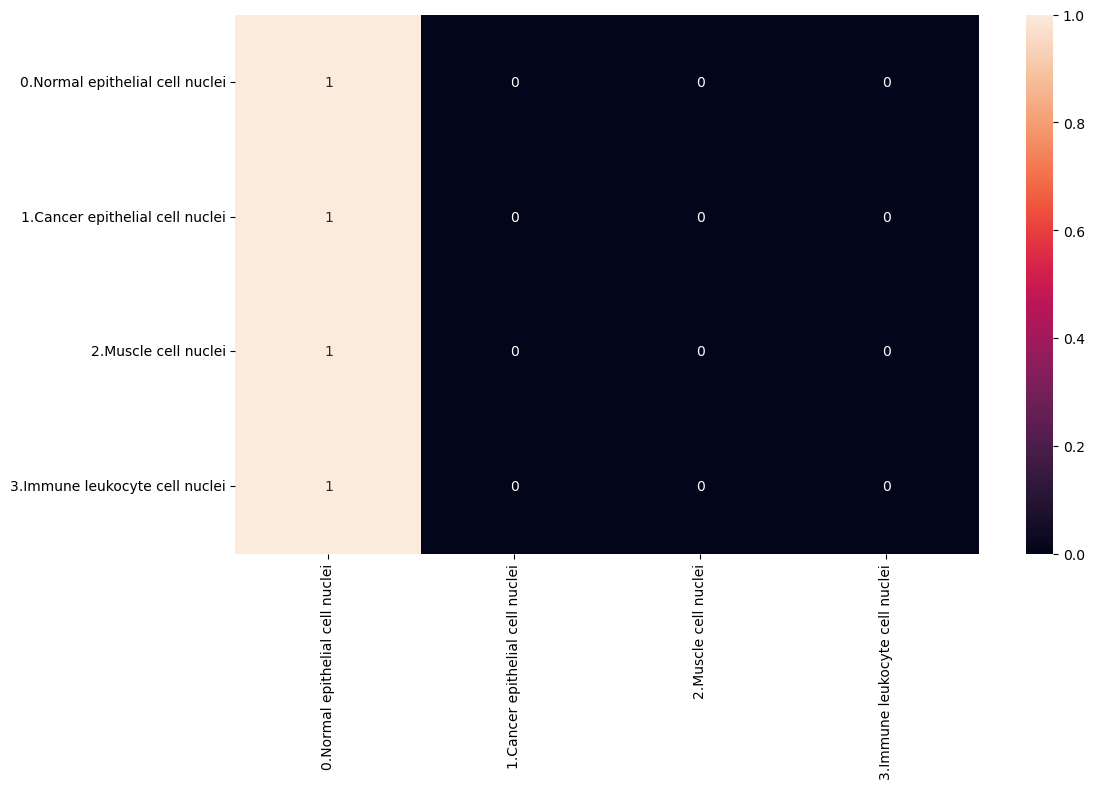

In [108]:
#model1 with original dataset
model_cm(valloader, model1)

the model 1 is behaving weirdly, classifying all the images to a specific class. Through different initiation the predictions get stuck to one class. In this case it is class0

### Model2

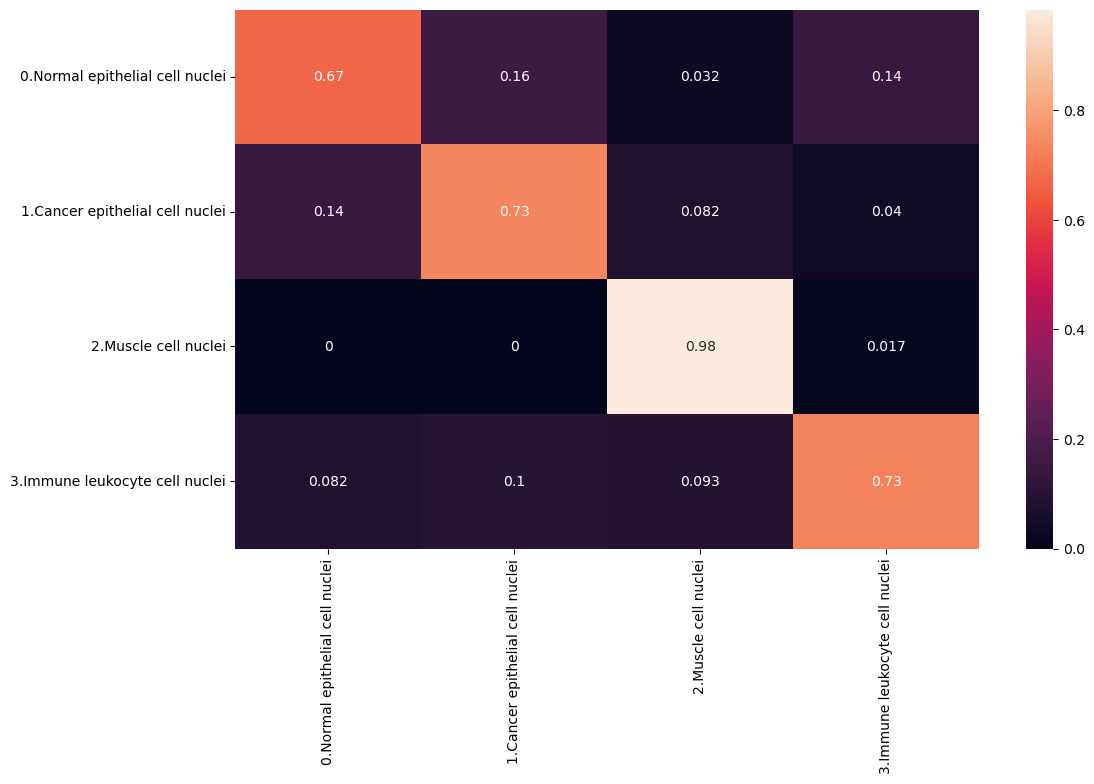

In [107]:
#model2 with original dataset
model_cm(valloader, model2)

model 2 with original data has a hard time identifying images of class0, sometimes classifying them as other classes. Despite that it has good results when classifying other class (especially class2 muscle image!).

## 3.3 Captum
here we try to understand how the model learns to classify an image, where is it doing well and where is it doing badly

In [86]:
# import urllib
# from PIL import Image
!pip install captum

import os
import json
from matplotlib.colors import LinearSegmentedColormap

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.2 MB/s eta 0:00:0000:01


### 3.3.1 comparing model prediction with ground labels

In [137]:
#extracting one minibatch from validation data
for i_batch8, sample_batched8 in enumerate(valloader):
        img8 = sample_batched8['image'].float()#need to change to float else will be incompatible with bias/weight
        labels8 = sample_batched8['labels'].flatten() #need to flatten to 1d or 0d, else there will error where the loss fn can't deal with multiclass
        break

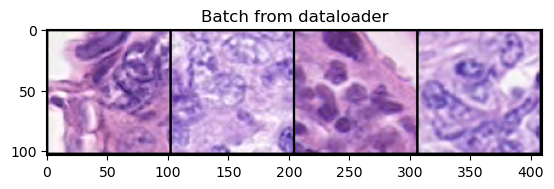

In [138]:
show_labels_batch(sample_batched8)

### Model1

In [139]:
output8 = model1(img8.to(device))
output8 = F.softmax(output8, dim=1)
prediction_score, pred_label_idx1 = torch.topk(output8, 1)


pred_label_idx1.squeeze_()
# predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('GroundTruth: ', sample_batched8['labels'].flatten())
print('Predicted cl:', pred_label_idx1)

GroundTruth:  tensor([1, 0, 3, 1])
Predicted cl: tensor([0, 0, 0, 0], device='cuda:0')


as shown in the confusion matrix, **model1** classifies everything as class0. It would be interesting to see what the attributions say about the judgement of **model1**

### Model2

In [140]:
output8 = model2(img8.to(device))
output8 = F.softmax(output8, dim=1)
prediction_score, pred_label_idx2 = torch.topk(output8, 1)


pred_label_idx2.squeeze_()
# predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('GroundTruth: ', sample_batched8['labels'].flatten())
print('Predicted cl:', pred_label_idx2)

GroundTruth:  tensor([1, 0, 3, 1])
Predicted cl: tensor([1, 0, 3, 1], device='cuda:0')


In this sample batch, model2 clasified all 4 images correctly (further confirms that the accuracy shown during training is faulty.<br>
With that in mind, we still want to understand more about **model2**, particularly from  the confusion matrix shown above, **model2** has a tendency of *classifying class0 images as other classes*. why is that the case?

### 3.3.2 gradient-based attribution
using integrated gradients, we can compute attributions and visualize it to better understand how the model learn and classify an image. 

### Model1

In [143]:
print('GroundTruth: ', sample_batched8['labels'].flatten())
print('Predicted cl:', pred_label_idx1)
#calculate the integrated gradients & attributions using Captum library
integrated_gradients1 = IntegratedGradients(model1)
attributions_ig1 = integrated_gradients1.attribute(img8.to(device), target=pred_label_idx1, n_steps=200)

GroundTruth:  tensor([1, 0, 3, 1])
Predicted cl: tensor([0, 0, 0, 0], device='cuda:0')


AssertionError: Cannot normalize by scale factor = 0

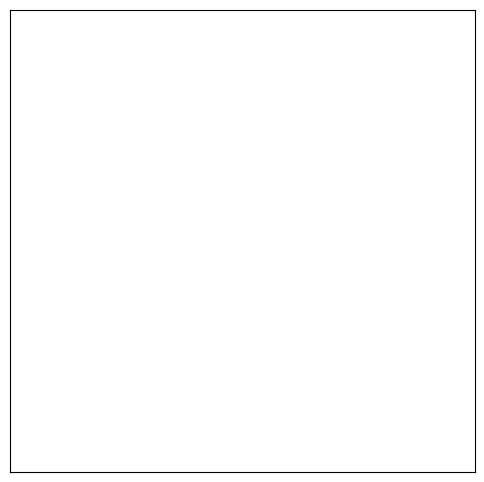

In [144]:
default_cmap1 = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig1[1].squeeze().cpu().detach().numpy(), (1,2,0)),
                             original_image=np.transpose(img8.to(device)[1].squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap1,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

There might be an error in the model itself, causing the visualize_image_attr to fail, saying the below error - we will proceed with the attribution on model 2
> AssertionError: Cannot normalize by scale factor = 0

### Model2

In [156]:
print('GroundTruth: ', sample_batched8['labels'].flatten())
print('Predicted cl:', pred_label_idx2)
#calculate the integrated gradients & attributions using Captum library
integrated_gradients2 = IntegratedGradients(model2)
attributions_ig2 = integrated_gradients2.attribute(img8.to(device), target=pred_label_idx2, n_steps=200)

GroundTruth:  tensor([1, 0, 3, 1])
Predicted cl: tensor([1, 0, 3, 1], device='cuda:0')


In [151]:
default_cmap2 = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

# _ = viz.visualize_image_attr(np.transpose(attributions_ig2[1].squeeze().cpu().detach().numpy(), (1,2,0)),
#                              original_image=np.transpose(img8.to(device)[1].squeeze().cpu().detach().numpy(), (1,2,0)),
#                              method='heat_map',
#                              cmap=default_cmap2,
#                              show_colorbar=True,
#                              sign='positive',
#                              outlier_perc=1)

In [153]:
noise_tunnel2 = NoiseTunnel(integrated_gradients2)

# attributions_ig_nt2 = noise_tunnel2.attribute(img8.to(device), nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx2)
# _ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt2[1].squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       np.transpose(img8.to(device)[1].squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       ["original_image", "heat_map"],
#                                       ["all", "positive"],
#                                       cmap=default_cmap2,
#                                       show_colorbar=True)

#### Model2 on image class0 (2nd image in mini batch)

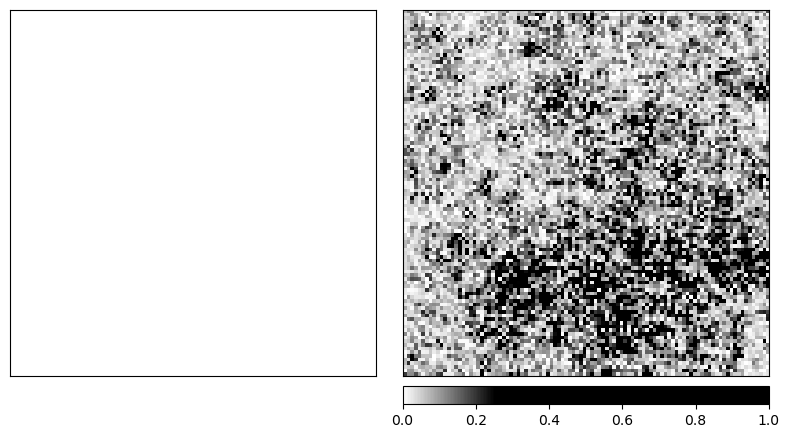

In [154]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap2 = GradientShap(model2)

# Defining baseline distribution of images
rand_img_dist2 = torch.cat([img8.to(device) * 0, img8.to(device) * 1])

attributions_gs2 = gradient_shap2.attribute(img8.to(device),
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist2,
                                          target=pred_label_idx2)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs2[1].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(img8.to(device)[1].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap2,
                                      show_colorbar=True)


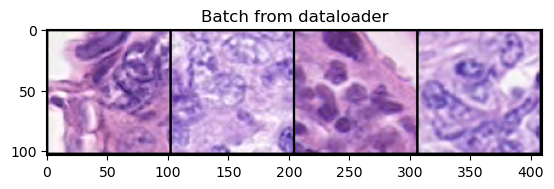

In [162]:
show_labels_batch(sample_batched8) #mini batch original image for comparison

There is some error here that does not show the original image for comparison...<br>
for the time being we can scroll up to check the last image shown in the minibatch, from the cell right under 3.3.1

The gradient based attribution shows that model2:
* have **strong attributions** in the **whiter areas** for image **class0** (**bottom right** of **2nd image **in this mini batch)
this may be the reason that **class0** is harder to classify, as there can be **white sparse areas** in **other cells** as well (see other images in the minibatch - they **all have white sparse areas**!)

# 4. Hyperparameter Tuning
we are using Ray Tune for parameter tuning, the hyperparameters we are going to tune include:
* learning rate
* weight decay
* momentum

In [165]:

from functools import partial
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
# from ray.air import session

## 4.1 Modified training function
to perform hyperparameter tuning with RayTune, we have to redefine the training function similar to the one we have above, but with the hyperparameters subbed up with a list of configs. <br>
The configs is a dictionary of hyperparameters paired with its search space<br><br>
In the train function we will also define a checkpoint, where the validation loss and accuracy is send to Ray Tune. Ray Tune will then perform **early stopping** accordingly (if validation results goes bad, that is).


In [169]:
#we dont have time to learn about newer ray versions so 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### The training function 
* that will perform training for model2, similar to the training function above, for 10 epochs.
* for each epoch, the model is trained (and back-prop) and validated, with all loss and accuracy data recorded
* the recorded results are reported to ray tune, which keeps a **checkpoint** - crucial for early stopping!
* the **hyperparameters** we want to tune is subbed out with the *config search space* (which will be defined later) - in this case it is **learning rate (lr)** and **weight decay (wd)**

In [304]:
#this is for model2 specifically!
def train_hpt2(config, checkpoint_dir=None, data_dir=None):
    net = model2
#########
####enabling multiple GPU support
#########
#     device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
#         device = "cuda"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)
#########
####defining loss functions and optimizer
#########
    criterion = nn.CrossEntropyLoss()
    weighted_loss_fn = nn.CrossEntropyLoss(weight = weights, reduction='sum')
#     optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=config["mt"])
    optimizer = optim.Adam(net.parameters(), lr=config["lr"], weight_decay=config["wd"])

#########
####setting up checkpoint
#########
    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
#########
####starting with the epoch, training first
#########
    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        net.train()
        for i_batch, sample_batched in enumerate(trainloader):
            img = sample_batched['image'].float()#need to change to float else will be incompatible with bias/weight
            labels = sample_batched['labels'].flatten() #need to flatten to 1d or 0d, else there will error where the loss fn can't deal with multiclass
            output = net(img.to(device))
            loss = weighted_loss_fn(output, labels.to(device))#use weighted loss function for training
#             loss = custom_loss(output, labels.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0
#########
####validation after training, each epoch
#########
        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i_batch, sample_batched in enumerate(valloader):
            with torch.no_grad():
                inputs = sample_batched['image'].float()#need to change to float else will be incompatible with bias/weight
                labels = sample_batched['labels'].flatten() #need to flatten to 1d or 0d, else there will error where the loss fn can't deal with multiclass
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                predicted = outputs.argmax(dim=1, keepdim=True)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)#normal loss function for validation
                val_loss += loss.cpu().numpy()
                val_steps += 1
#########
####report the score
#########
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

### The main function 
that calls for the hyperparameter training function defined above, and shows the best final hyperparameter


In [305]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
#     data_dir = os.path.abspath("./data")
#     load_data(data_dir)
    config = {
        "wd": tune.loguniform(1e-5, 1e-3),
        "lr": tune.loguniform(1e-4, 1e-1),
#         "batch_size": tune.choice([2, 4, 8, 16])
#         "mt": tune.choice([0.99, 0.7, 0.95, 0.90])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
#         partial(train_hpt2, data_dir=data_dir),
        partial(train_hpt2),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

#     best_trained_model = Net(best_trial.config["l1"], best_trial.config["l2"])
#     device = "cpu"
#     if torch.cuda.is_available():
#         device = "cuda:0"
#         if gpus_per_trial > 1:
#             best_trained_model = nn.DataParallel(best_trained_model)
#     best_trained_model.to(device)
    best_trained_model = model2

    best_checkpoint_dir = best_trial.checkpoint.dir_or_data
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

#     test_acc = test_accuracy(best_trained_model, device)
#     print("Best trial test set accuracy: {}".format(test_acc))
    return best_trained_model


if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    final_model = main(num_samples=10, max_num_epochs=10, gpus_per_trial=1)

2023-03-27 14:58:53,903	WARNING worker.py:1851 -- Warning: The actor ImplicitFunc is very large (42 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2023-03-27 14:58:54,236	WARNING util.py:244 -- The `start_trial` operation took 1.622 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-03-27 14:58:54 (running for 00:00:10.11)
Memory usage on this node: 4.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/5.94 GiB heap, 0.0/2.97 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_hpt2_2023-03-27_14-58-44
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-------------+-------------+
| Trial name             | status   | loc              |          lr |          wd |
|------------------------+----------+------------------+-------------+-------------|
| train_hpt2_de6c9_00000 | RUNNING  | 172.19.2.2:22879 | 0.000755757 | 1.38592e-05 |
| train_hpt2_de6c9_00001 | PENDING  |                  | 0.000247667 | 6.83869e-05 |
| train_hpt2_de6c9_00002 | PENDING  |                  | 0.0485465   | 5.8293e-05  |
| train_hpt2_de6c9_00003 | PE

Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_hpt2_de6c9_00000,1.37169,2023-03-27_15-03-33,True,,9898531cb228474685fd23e80ee55717,3306876a24c7,10,0.790522,172.19.2.2,22879,True,271.818,27.8227,271.818,1679929413,0,,10,de6c9_00000,0.00978279
train_hpt2_de6c9_00001,1.43386,2023-03-27_15-04-10,True,,827ce50753db40fcace34373e9c9c010,3306876a24c7,1,0.832826,172.19.2.2,23152,True,27.9279,27.9279,27.9279,1679929450,0,,1,de6c9_00001,0.0109558
train_hpt2_de6c9_00002,0.654762,2023-03-27_15-04-47,True,,4dcb3be131754edcaa1c246fa4e22943,3306876a24c7,1,28.7506,172.19.2.2,23218,True,27.8353,27.8353,27.8353,1679929487,0,,1,de6c9_00002,0.0091331
train_hpt2_de6c9_00003,1.43783,2023-03-27_15-05-50,True,,1ac0fa19c6f24039826dd5dfeafcbd57,3306876a24c7,2,0.809991,172.19.2.2,23289,True,53.7027,25.7376,53.7027,1679929550,0,,2,de6c9_00003,0.00850749
train_hpt2_de6c9_00004,1.2381,2023-03-27_15-06-53,True,,1b1cc81a89ac447eab716ed0c126d43f,3306876a24c7,2,1.1062,172.19.2.2,23382,True,53.7075,26.2472,53.7075,1679929613,0,,2,de6c9_00004,0.00739264
train_hpt2_de6c9_00005,1.08466,2023-03-27_15-07-31,True,,dfcd05d1dc0f4ffc846b420672cca5e9,3306876a24c7,1,1.23836,172.19.2.2,23479,True,28.0949,28.0949,28.0949,1679929651,0,,1,de6c9_00005,0.00814247
train_hpt2_de6c9_00006,1.37963,2023-03-27_15-08-08,True,,fb0bc599c69f4aceb36ff4177940e4bd,3306876a24c7,1,1.25595,172.19.2.2,23548,True,27.9021,27.9021,27.9021,1679929688,0,,1,de6c9_00006,0.00469089
train_hpt2_de6c9_00007,1.57275,2023-03-27_15-08-45,True,,6fc6dfe8d8224acd86efe3eac5f7187a,3306876a24c7,1,0.926487,172.19.2.2,23621,True,28.0147,28.0147,28.0147,1679929725,0,,1,de6c9_00007,0.0051198
train_hpt2_de6c9_00008,1.18254,2023-03-27_15-09-21,True,,534f4f770ff94964b3dcd1b2791960b8,3306876a24c7,1,13.3329,172.19.2.2,23690,True,27.9509,27.9509,27.9509,1679929761,0,,1,de6c9_00008,0.00736499
train_hpt2_de6c9_00009,1.32143,2023-03-27_15-10-25,True,,1cba80cb012840c5a26df30f32107cfd,3306876a24c7,2,0.944709,172.19.2.2,23757,True,54.4618,26.5964,54.4618,1679929825,0,,2,de6c9_00009,0.00604463


== Status ==
Current time: 2023-03-27 14:59:38 (running for 00:00:54.30)
Memory usage on this node: 6.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.7650218100222961
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/5.94 GiB heap, 0.0/2.97 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_hpt2_2023-03-27_14-58-44
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-------------+-------------+----------+------------+----------------------+
| Trial name             | status   | loc              |          lr |          wd |     loss |   accuracy |   training_iteration |
|------------------------+----------+------------------+-------------+-------------+----------+------------+----------------------|
| train_hpt2_de6c9_00000 | RUNNING  | 172.19.2.2:22879 | 0.000755757 | 1.38592e-05 | 0.765022 |    1.52249 |                    

2023-03-27 15:03:34,885	WARNING util.py:244 -- The `start_trial` operation took 0.525 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-03-27 15:03:39 (running for 00:04:55.75)
Memory usage on this node: 5.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: -1.0126664992126206 | Iter 4.000: -0.7761903504136378 | Iter 2.000: -0.8097533071955676 | Iter 1.000: -0.7650218100222961
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/5.94 GiB heap, 0.0/2.97 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_hpt2_2023-03-27_14-58-44
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-------------+-------------+----------+------------+----------------------+
| Trial name             | status     | loc              |          lr |          wd |     loss |   accuracy |   training_iteration |
|------------------------+------------+------------------+-------------+-------------+----------+------------+----------------------|
| train_hpt2_de6c9_00001 | RUNNING    | 172.19.2.2:23152 | 0.00

2023-03-27 15:04:11,912	WARNING util.py:244 -- The `start_trial` operation took 0.546 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-03-27 15:04:16 (running for 00:05:32.78)
Memory usage on this node: 5.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -1.0126664992126206 | Iter 4.000: -0.7761903504136378 | Iter 2.000: -0.8097533071955676 | Iter 1.000: -0.7989237918937333
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/5.94 GiB heap, 0.0/2.97 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_hpt2_2023-03-27_14-58-44
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-------------+-------------+----------+------------+----------------------+
| Trial name             | status     | loc              |          lr |          wd |     loss |   accuracy |   training_iteration |
|------------------------+------------+------------------+-------------+-------------+----------+------------+----------------------|
| train_hpt2_de6c9_00002 | RUNNING    | 172.19.2.2:23218 | 0.04

2023-03-27 15:04:48,891	WARNING util.py:244 -- The `start_trial` operation took 0.519 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-03-27 15:04:53 (running for 00:06:09.76)
Memory usage on this node: 4.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -1.0126664992126206 | Iter 4.000: -0.7761903504136378 | Iter 2.000: -0.8097533071955676 | Iter 1.000: -0.8328257737651704
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/5.94 GiB heap, 0.0/2.97 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_hpt2_2023-03-27_14-58-44
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-------------+-------------+-----------+------------+----------------------+
| Trial name             | status     | loc              |          lr |          wd |      loss |   accuracy |   training_iteration |
|------------------------+------------+------------------+-------------+-------------+-----------+------------+----------------------|
| train_hpt2_de6c9_00003 | RUNNING    | 172.19.2.2:23289 | 0

2023-03-27 15:05:51,909	WARNING util.py:244 -- The `start_trial` operation took 0.519 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-03-27 15:05:56 (running for 00:07:12.79)
Memory usage on this node: 4.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: -1.0126664992126206 | Iter 4.000: -0.7761903504136378 | Iter 2.000: -0.8098721232206103 | Iter 1.000: -0.7989237918937333
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/5.94 GiB heap, 0.0/2.97 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_hpt2_2023-03-27_14-58-44
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------+------------+------------------+-------------+-------------+-----------+------------+----------------------+
| Trial name             | status     | loc              |          lr |          wd |      loss |   accuracy |   training_iteration |
|------------------------+------------+------------------+-------------+-------------+-----------+------------+----------------------|
| train_hpt2_de6c9_00004 | RUNNING    | 172.19.2.2:23382 | 0

2023-03-27 15:06:54,940	WARNING util.py:244 -- The `start_trial` operation took 0.536 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-03-27 15:06:59 (running for 00:08:15.81)
Memory usage on this node: 4.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 8.000: -1.0126664992126206 | Iter 4.000: -0.7761903504136378 | Iter 2.000: -0.8099909392456529 | Iter 1.000: -0.7731152631480385
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/5.94 GiB heap, 0.0/2.97 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_hpt2_2023-03-27_14-58-44
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------+------------+------------------+-------------+-------------+-----------+------------+----------------------+
| Trial name             | status     | loc              |          lr |          wd |      loss |   accuracy |   training_iteration |
|------------------------+------------+------------------+-------------+-------------+-----------+------------+----------------------|
| train_hpt2_de6c9_00005 | RUNNING    | 172.19.2.2:23479 | 0

2023-03-27 15:07:32,934	WARNING util.py:244 -- The `start_trial` operation took 0.529 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-03-27 15:07:37 (running for 00:08:53.80)
Memory usage on this node: 5.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: -1.0126664992126206 | Iter 4.000: -0.7761903504136378 | Iter 2.000: -0.8099909392456529 | Iter 1.000: -0.8029705184566045
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/5.94 GiB heap, 0.0/2.97 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_hpt2_2023-03-27_14-58-44
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+------------------------+------------+------------------+-------------+-------------+-----------+------------+----------------------+
| Trial name             | status     | loc              |          lr |          wd |      loss |   accuracy |   training_iteration |
|------------------------+------------+------------------+-------------+-------------+-----------+------------+----------------------|
| train_hpt2_de6c9_00006 | RUNNING    | 172.19.2.2:23548 | 0

2023-03-27 15:08:09,925	WARNING util.py:244 -- The `start_trial` operation took 0.514 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-03-27 15:08:14 (running for 00:09:30.79)
Memory usage on this node: 5.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 8.000: -1.0126664992126206 | Iter 4.000: -0.7761903504136378 | Iter 2.000: -0.8099909392456529 | Iter 1.000: -0.8328257737651704
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/5.94 GiB heap, 0.0/2.97 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_hpt2_2023-03-27_14-58-44
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------+------------+------------------+-------------+-------------+-----------+------------+----------------------+
| Trial name             | status     | loc              |          lr |          wd |      loss |   accuracy |   training_iteration |
|------------------------+------------+------------------+-------------+-------------+-----------+------------+----------------------|
| train_hpt2_de6c9_00007 | RUNNING    | 172.19.2.2:23621 | 0

2023-03-27 15:08:45,980	WARNING util.py:244 -- The `start_trial` operation took 0.563 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-03-27 15:08:50 (running for 00:10:06.85)
Memory usage on this node: 5.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -1.0126664992126206 | Iter 4.000: -0.7761903504136378 | Iter 2.000: -0.8099909392456529 | Iter 1.000: -0.87965618458542
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/5.94 GiB heap, 0.0/2.97 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_hpt2_2023-03-27_14-58-44
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------+------------+------------------+-------------+-------------+-----------+------------+----------------------+
| Trial name             | status     | loc              |          lr |          wd |      loss |   accuracy |   training_iteration |
|------------------------+------------+------------------+-------------+-------------+-----------+------------+----------------------|
| train_hpt2_de6c9_00008 | RUNNING    | 172.19.2.2:23690 | 0.0

2023-03-27 15:09:22,957	WARNING util.py:244 -- The `start_trial` operation took 0.531 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-03-27 15:09:27 (running for 00:10:43.83)
Memory usage on this node: 5.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 8.000: -1.0126664992126206 | Iter 4.000: -0.7761903504136378 | Iter 2.000: -0.8099909392456529 | Iter 1.000: -0.9264865954056698
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/5.94 GiB heap, 0.0/2.97 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_hpt2_2023-03-27_14-58-44
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+------------------------+------------+------------------+-------------+-------------+-----------+------------+----------------------+
| Trial name             | status     | loc              |          lr |          wd |      loss |   accuracy |   training_iteration |
|------------------------+------------+------------------+-------------+-------------+-----------+------------+----------------------|
| train_hpt2_de6c9_00009 | RUNNING    | 172.19.2.2:23757 | 0.00057667  

2023-03-27 15:10:25,161	INFO tune.py:763 -- Total run time: 702.17 seconds (700.88 seconds for the tuning loop).


== Status ==
Current time: 2023-03-27 15:10:25 (running for 00:11:40.90)
Memory usage on this node: 6.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 8.000: -1.0126664992126206 | Iter 4.000: -0.7761903504136378 | Iter 2.000: -0.8773502133412179 | Iter 1.000: -0.8868938072279057
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/5.94 GiB heap, 0.0/2.97 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_hpt2_2023-03-27_14-58-44
Number of trials: 10/10 (10 TERMINATED)
+------------------------+------------+------------------+-------------+-------------+-----------+------------+----------------------+
| Trial name             | status     | loc              |          lr |          wd |      loss |   accuracy |   training_iteration |
|------------------------+------------+------------------+-------------+-------------+-----------+------------+----------------------|
| train_hpt2_de6c9_00000 | TERMINATED | 172.19.2.2:22879 | 0.000755757 | 1.38592e-05

The output above is too length, we will copy and paste the result below:
The result is returned as below:
> Best trial config: {'wd': 1.3859244495551088e-05, 'lr': 0.00075575685367558}<br>
Best trial final validation loss: 0.7905224830937133<br>
Best trial final validation accuracy: 1.3716931216931216<br>

again, there may be calculations at fault here....we will proceed with the final_model as our best configured model regardless

# 5.Final Model
now that we have the best model configured, we can go ahead and produce predictions for the test set for our competition

In [306]:
final_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [311]:
#test the model against validation data, just for quick check
#extracting one minibatch from validation data
for i_batch0, sample_batched0 in enumerate(valloader):
        img0 = sample_batched0['image'].float()#need to change to float else will be incompatible with bias/weight
        labels0 = sample_batched0['labels'].flatten() #need to flatten to 1d or 0d, else there will error where the loss fn can't deal with multiclass
        break

output0 = final_model(img0.to(device))
output0 = F.softmax(output0, dim=1)
prediction_score0, pred_label_idx0 = torch.topk(output8, 1)


pred_label_idx0.squeeze_()
# predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('GroundTruth: ', sample_batched0['labels'].flatten())
print('Predicted cl:', pred_label_idx0)

GroundTruth:  tensor([3, 3, 1, 3])
Predicted cl: tensor([1, 0, 3, 1], device='cuda:0')


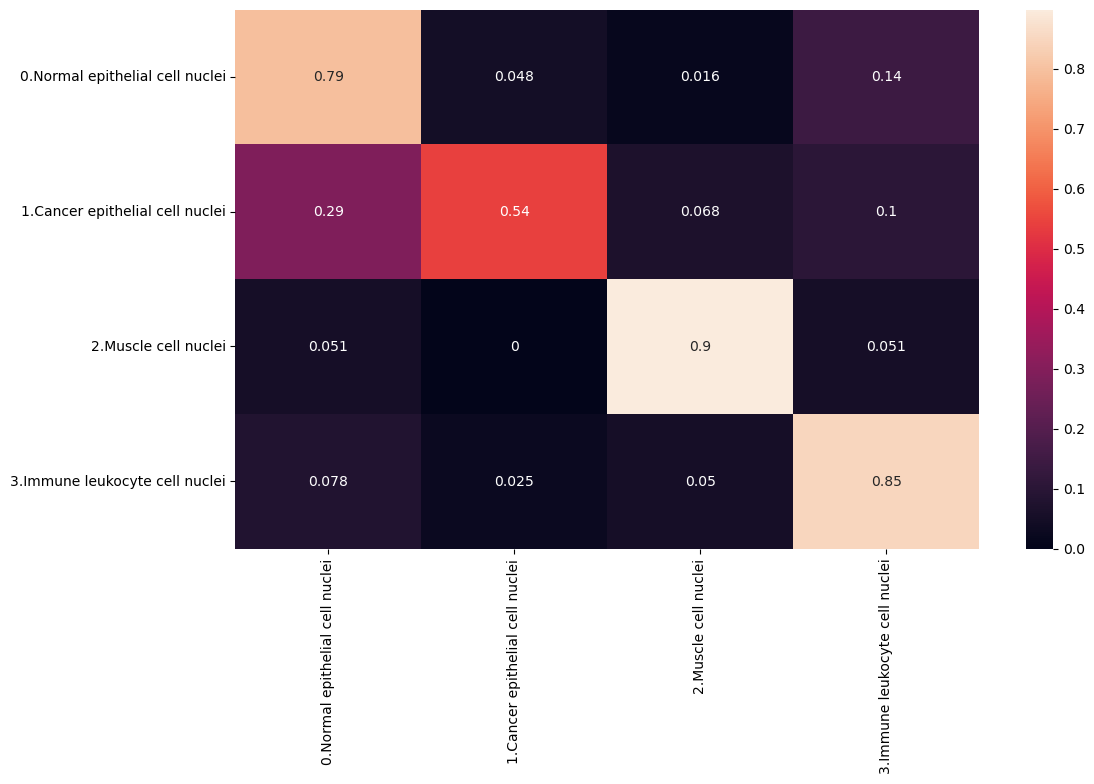

In [310]:
#model2 with original dataset
model_cm(valloader, final_model)

## 5.1 making predictions on test data
we will use the final model to produce prediction below

In [312]:
#load the train.csv into a dataframe
output_frame = pd.read_csv('/kaggle/input/deep-learning-for-msc-2022-23/example.csv')
output_frame.head()

,Filename,Label
0,10001.png,0
1,10002.png,0
2,10003.png,0
3,10004.png,0
4,10005.png,0


In [313]:
output_frame.shape

(5041, 2)

In [314]:
#loading test images with dataloader
test_dataset = CellsDataset(df=output_frame, root_dir='/kaggle/input/deep-learning-for-msc-2022-23/test/',
                                   transform = ToTensor())

testloader = DataLoader(test_dataset, batch_size=1)

In [315]:
#iterate the batches from dataloader to produce predictions output

res = []
final_model.eval()

for i_batch, sample_batched in enumerate(testloader):
        
        img = sample_batched['image'].float()#need to change to float else will be incompatible with bias/weight
        labels = sample_batched['labels'].flatten() #need to flatten to 1d or 0d, else there will error where the loss fn can't deal with multiclass
        output = final_model(img.to(device))
        output = F.softmax(output, dim=1)
        prediction_score, pred_label_idx = torch.topk(output, 1)
        pred_label_idx.squeeze_()
#         print(pred_label_idx, pred_label_idx.item())
        res.append(pred_label_idx.item())


In [316]:
res = np.array(res)
res

array([2, 2, 3, ..., 0, 2, 3])

In [318]:
#input the results to the dataframe
output_frame['Label'] = res
output_frame.head(100)

,Filename,Label
0,10001.png,2
1,10002.png,2
2,10003.png,3
3,10004.png,0
4,10005.png,3
...,...,...
95,10096.png,3
96,10097.png,0
97,10098.png,1
98,10099.png,0


In [319]:
#output the dataframe into a csv
output_frame.to_csv('submission3.csv', index=False)

## Future Enhancement:
Due to the time and resource limitation, there are some things I think will be interesting to try/add to this project.
1. solving the CPU bottleneck and practice data augmentation
* this will give the model more data to practice without having the data being imbalance. we can try moving the data augmentation on to the gpu?
2. early stopping
* stopping right before the validation result gets worse
3. use newer version of ray - ray.air.session
* may want to learn about it for future use
4. more interpretation on model1 to understand why is it behaving strange
5. more image processing (normalization etc.)
* may improve the model performance if we normalize the images?